## The downloaded data from the database requires some additional manipulations
We load it, verify that everything's in place and start slicing it.


In [9]:
import sqlalchemy as sqlalc
import pandas 
import sorting
import numpy
import matplotlib.pyplot as plt

A frequently omitted part - the configuration of Pandas

In [13]:
# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)

Other options are here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html

In [10]:
conn_source = sqlalc.create_engine(sorting.HOME_DATABASE_URI)
conn_target = sqlalc.create_engine(sorting.TARGET_DATABASE_URI)

permits = pandas.read_sql_table(table_name=sorting.PERMITS_TABLE, con=conn_source)

Let's take a 'birds eye view' (in loglog scale) at what we got here.
I think the absolute maximum of a 'reported cost' (whatever that might be) is $10Bn, am I correct?

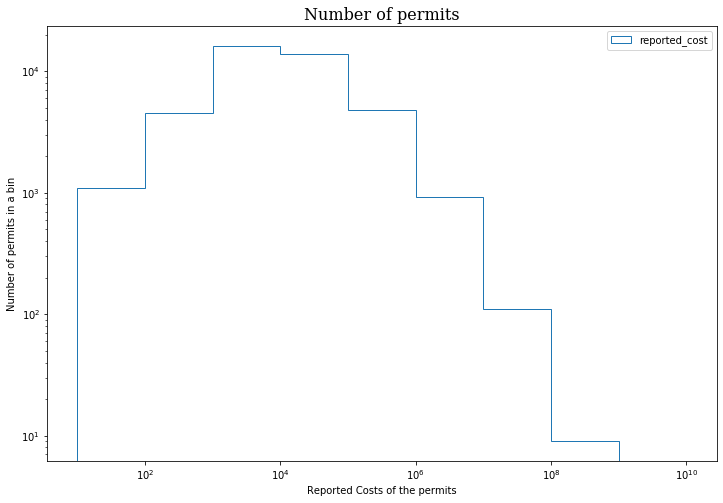

In [11]:
reported_costs = permits.loc[:, ['reported_cost']]

font_d = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}
bins = numpy.logspace(start=1, stop=10, num=10, endpoint=True)
Fig_1 = reported_costs.plot(bins=bins, kind='hist', histtype='step', loglog=True, figsize=(12,8))
Fig_1.set_title("Number of permits", fontdict=font_d)
Fig_1.set_xlabel('Reported Costs of the permits')
Fig_1.set_ylabel('Number of permits in a bin')
plt.show()

Indeed I was right! There are no 10B-dollar permits... but there are 10 in the range of 100M - 1B (!!!)

## Labeling permits with 'sizes'
The overall 'psychological' sizes (marked in the same way as clothing sizes) of consumers and builders is approximately like this:
- [0,100],                    # XXS
- (100, 1000],                # XS
- (1000, 10000],              # S
- (10000, 100000],            # M
- (100000, 1000000],          # L
- (1000000, 10000000],        # XL
- (10000000, 100000000],      # XXL
- (100000000, 10000000000]     # XXXL

In [12]:
sizes = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL']
bins_ends = [0.0, 100.0, 1000.0, 10000, 100000, 1000000, 10000000, 100000000, 10000000000]

permits['size'] = pandas.cut(reported_costs['reported_cost'], bins=bins_ends, labels=sizes)

In [7]:
plt.figure(10,10)

TypeError: from_bounds() argument after * must be an iterable, not int

In [15]:
# all types of permits
types = list(permits['permit_type'].unique())  # unique returns a numpy Array
permit_types = pandas.DataFrame(types, columns=['permit_type'])
permit_types.to_sql(name=sorting.constants.PERMIT_TYPES_TABLE,
                    con=conn_target, if_exists='replace',
                    index=False)
print('Saved permit types to ', sorting.constants.PERMIT_TYPES_TABLE, '\n')

Saved permit types to  permit_types 



In [16]:
# create/save separate auxiliary table for each type
for type in types:
    permits_of_type = pandas.DataFrame()
    permits_of_type = permits[permits['permit_type'] == type]
    permits_of_type.info() # print out a summary of what will be saved
    permits_of_type.to_sql(name=type,
                           con=conn_target, if_exists='replace',
                           index=False)        # with indexes it can be reassembled

    print('Saved table ', type, '  with its index\n')
else:
    print('Done saving to:  ', sorting.constants.TARGET_DATABASE_URI)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15808 entries, 0 to 48932
Columns: 113 entries, id to contact_14_zipcode
dtypes: datetime64[ns](2), float64(6), int64(2), object(103)
memory usage: 13.7+ MB
Saved table  PERMIT - ELECTRIC WIRING   with its index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4036 entries, 9 to 48847
Columns: 113 entries, id to contact_14_zipcode
dtypes: datetime64[ns](2), float64(6), int64(2), object(103)
memory usage: 3.5+ MB
Saved table  PERMIT - SIGNS   with its index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9493 entries, 11 to 48879
Columns: 113 entries, id to contact_14_zipcode
dtypes: datetime64[ns](2), float64(6), int64(2), object(103)
memory usage: 8.3+ MB
Saved table  PERMIT - RENOVATION/ALTERATION   with its index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1632 entries, 19 to 48818
Columns: 113 entries, id to contact_14_zipcode
dtypes: datetime64[ns](2), float64(6), int64(2), object(103)
memory usage: 1.4+ MB
Saved table 